# Dependencies

In [1]:
import numpy as np

# restore removed NumPy aliases so old code in networkx (and elsewhere) still works
if not hasattr(np, 'float_'):
    np.float_ = np.float64
if not hasattr(np, 'int'):
    np.int = int
import igraph as ig
import random
import subprocess
from collections import defaultdict
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import time
import pickle
from collections import Counter
import networkx as nx
import os
import csv
import tempfile
from pathlib import Path
import subprocess
import math, time, random
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import math
import sys

if len(sys.argv) < 2:
    print("Specify experiment: SA or lr")
    sys.exit(1)

mode = sys.argv[1]



# Common part

## Uniqueness

In [2]:
# Compuate equivalent class.
def ig_to_nauty(g):
    graph = "n " + str(g.vcount()) + "\n"
    graph += "g\n"
    for n in g.vs.indices:
        graph += str(n) + ":"
        for m in g.neighbors(n):
            graph += " " + str(m)
        graph += ";\n"
    
    return graph
def ig_to_dre(g):
    """
    Converts an igraph graph to the .dre format required by the anon binary.
    """
    lines = [f"!n={g.vcount()}"]
    for i in range(g.vcount()):
        neighbors = g.neighbors(i)
        end = '.' if i == g.vcount() - 1 else ';'
        lines.append(f"{i}: {' '.join(map(str, neighbors))}{end}")
    return '\n'.join(lines)

def computeEQ(G, criteria='nm'):
    '''
    Input: orignal graph
    Output: a dict of equivalent class and the list of nodes of the eqvialent class. i.e. {'class id': [nodes]}
    '''
    P = defaultdict(list)
    if criteria == 'dk':
        # 1) write the graph in .dre format to a temp file
        dre_text = ig_to_dre(G)
        tf = tempfile.NamedTemporaryFile(mode='w', suffix='.dre', delete=False)
        tf.write(dre_text)
        tf.flush()
        tf.close()
        try:
            # 2) locate the anon binary (adjust if your structure differs)
            project_root = Path.cwd().parent    # if cwd is …/dkAnonymity/nauty27r4
            anon_bin = project_root / "bin" / "anon"

            # 3) run: ./bin/anon <temp.dre> -d 1 -eq -s 0
            proc = subprocess.Popen(
                [str(anon_bin), tf.name, "-d", "3", "-eq", "-s", "0"],
                stdout=subprocess.PIPE, stderr=subprocess.PIPE
            )
            out, err = proc.communicate()
            res = out.decode()

            # 4) parse the equivalence classes
            lines = res.splitlines()
            # find the block
            try:
                start = lines.index("Start equivalence classes.") + 1
                end   = lines.index("End equivalence classes.")
                eq_lines = lines[start:end]
            except ValueError:
                # fallback: any line of pure integers
                eq_lines = [l for l in lines if l.strip() and all(tok.isdigit() for tok in l.split())]

            for line in eq_lines:
                members = list(map(int, line.split()))
                # use a tuple key so distinct classes map correctly
                P[tuple(sorted(members))] = members

        finally:
            # remove the temporary file
            os.unlink(tf.name)
    
    elif criteria == 'nm':
        for node in G.vs.indices:
            neighborhood = G.neighbors(node)
            n = len(neighborhood) + 1
            neighborhood.append(node)
            sg = G.subgraph(neighborhood)
            m = sg.ecount()
            P[(n, m)].append(node)

    return P

In [3]:
# Compute the uniqueness of the network.
def uniqueness(G, criteria):
    '''
    Input: original graph
    Output: a number of uniquendess, and a list of unique nodes
    '''
    u = 0
    n = G.vcount()
    p = computeEQ(G, criteria)
    unique_nodes = set()
    k = 2
    for cl in p:
        # print(cl, p[cl])
        if len(p[cl]) < k:
            unique_nodes.update(p[cl])
    u = len(unique_nodes) / n
    return u, unique_nodes

## Initialization

In [ ]:
G_origin = nx.Graph()
document='fb-pages-food'  # specify the dataset you want to use

# edges = [
#     (1, 2), (1, 3), (2, 3), (2, 4), (3, 5), (4, 5),
#     (4, 6), (6, 7), (6, 8), (7, 9), (8, 9), (8, 10), (9, 10)
# ]
# G_origin.add_edges_from(edges)
# read data

# copenet-sms
with open('./datasets/sms.csv', newline='') as f:
    lines = csv.reader(f, delimiter=',')
    if document == 'sms':
        for line in lines:
            G_origin.add_edge(line[1], line[2])
# copenet-fb
with open('./datasets/fb_friends.csv', newline='') as f:
    lines = csv.reader(f, delimiter=',')
    if document == 'fb_friends':
        for line in lines:
            G_origin.add_edge(line[0], line[1])

# CollegeMsg
with open('./datasets/CollegeMsg.txt') as f:
        if document == 'CollegeMsg':
            for line in f:
                edge = line.strip().split(' ')
                G_origin.add_edge(edge[0], edge[1])
# ca-grqc        
with open('./datasets/CA-GrQc.txt') as f:
        if document == 'CA-GrQc':
            for line in f:
                edge = line.strip().split('\t')
                G_origin.add_edge(edge[0], edge[1])

# ego-fb
with open('./datasets/facebook_combined.txt') as f:
        if document == 'facebook_combined':
            for line in f:
                edge = line.strip().split(' ')
                G_origin.add_edge(edge[0], edge[1])
# fb-pages-food
with open('./datasets/fb-pages-food.txt', newline='') as f:
    if document == 'fb-pages-food':
        reader = csv.reader(f, delimiter=',')
        for line in reader:
            node1, node2 = int(line[0]), int(line[1])
            G_origin.add_edge(node1, node2)
# CollegeMsg
with open('./datasets/soc-hamsterster.txt') as f:
        if document == 'soc-hamsterster':
            for line in f:
                edge = line.strip().split(' ')
                G_origin.add_edge(edge[0], edge[1])          
        
G_origin = ig.Graph.from_networkx(G_origin)
criteria = 'nm'
U, unodes_origin = uniqueness(G_origin, criteria)
print("Uniqueness:", U)

# info of empirical network
ig.summary(G_origin)

print("ACC:", G_origin.transitivity_avglocal_undirected(mode="zero"), "Transitivity:", G_origin.transitivity_undirected())
print("U_nm:", U)
E0 = set(G_origin.get_edgelist())  # all possible edges in the original graph


Uniqueness: 0.24896949711459193
IGRAPH U--- 2426 16630 -- 
+ attr: _nx_name (v)
ACC: 0.5375333362074072 Transitivity: 0.2313875897470065
U_nm: 0.24896949711459193


In [5]:
# initialize
STEP = 10
# CALCULATE_TIME = G_origin.ecount() // STEP
CALCULATE_TIME = G_origin.ecount() // STEP

x = list(range(STEP, (CALCULATE_TIME+1)*STEP, STEP))
u_of_10 = np.full((10, CALCULATE_TIME+1), U)

In [6]:
# Find all edges between unique nodes.
def getEdgeListUnique(G, node_list):
    '''
    Input: original graph, and list of unique nodes
    Output: list of edges between unique nodes
    '''
    edges = G.get_edgelist()
    res = []
    for edge in edges:
        if (edge[0] in node_list) and (edge[1] in node_list):
            res.append(edge)
    
    return res

## U/A

In [7]:
# Compute the U and A of all edges.
def edgeUA(G, unodes):
    '''
    Input: original graph, and list of unique nodes
    Output: U, A, and directly connected unique nodes
    '''
    edges = G.get_edgelist()
    res = {}
    for u, v in edges:
        f = []
        node_list = [u, v]
        neighbors_u = set(G.neighbors(u))
        neighbors_v = set(G.neighbors(v))
        node_list += list(neighbors_u.intersection(neighbors_v))
        for node in node_list:
            if node in unodes:
                f.append(1)
            else:
                f.append(0)
        res[u,v] = (sum(f), len(f)-sum(f), f[0]+f[1])

    return res

In [8]:
# Delete edges based on U/A
def deleteUA(G, num, ua):
    '''
    Input:
        G: original graph
        num: number of edges need to be deleted
        ua: U, A, number of directly connected unique nodes
    Output: modified graph
    '''
    p = []
    edges = []
    edge_candidates = G.get_edgelist()
    for j in edge_candidates:
        p.append((ua[j][0]+0.01)/(ua[j][1]+0.01))
    for _ in range(num):
        edge = random.choices(edge_candidates, weights=tuple(p))[0]
        index = edge_candidates.index(edge)
        edges.append(G.get_eid(edge[0], edge[1]))
        p[index] = 0

    G.delete_edges(edges)

    return G

In [9]:
def UA1Round(G, U, edge_vec, STEP, CALCULATE_TIME, criteria):
    u_ua = [U]
    
    t0 = time.time()
    for i in range(CALCULATE_TIME):
        # delete-U/A
        G = deleteUA(G, STEP, edge_vec)
        new_u_ua, unodes_ua = uniqueness(G, criteria)
        u_ua.append(new_u_ua)
        edge_vec = edgeUA(G, unodes_ua)
    #     print("u_ua:", new_u_ua)
    t1 = time.time()
    
    return u_ua, t1-t0, G

In [10]:
# G_ua = G_origin.copy()
# edge_vec = edgeUA(G_origin, unodes_origin)

# u_ua, t_ua, _ = UA1Round(G_ua, U, edge_vec, STEP, CALCULATE_TIME, 'nm')
# print('Time of delete-U/A: {:.3f}s'.format(t_ua))

# with open('./intermediate results/UA-CopenFB-10-NM-10STEP.txt', 'wb') as f:
#     pickle.dump(u_ua, f)

## Logistics Regression

In [11]:
# Transfer effect of uniqueness to label.
def value2label(x):
    if x>=0:
        return 0
    else:
        return 1

In [12]:
# Delete edges based on Logistic Regression Classification.
def LRDelete(G, num, model, unodes):
    '''
    Input:
        G: original graph
        num: the number of edges need to be deleted
        model: the trained classifier
        unodes: list of unique nodes
    Output: modified graph
    '''
    edges = G.get_edgelist()
    edge_vector = edgeUA(G, unodes)
    n = G.vcount()
    m = G.ecount()
    df = pd.DataFrame(columns=['N_nodes', 'N_edges', 'max', 'min', 'U', 'A', 'direct_connected_nodes', 'triangles'])
    for e in edges:
        df.loc[G.get_eid(e[0], e[1]), :] = [n, m, max(G.degree(e[0]), G.degree(e[1])), min(G.degree(e[0]), G.degree(e[1])), 
                                edge_vector[e][0], edge_vector[e][1], edge_vector[e][2], edge_vector[e][0]+edge_vector[e][1]-2]
    p = model.predict_proba(df)
    p = p[:,1]
    index = np.argsort(p)[-num:]
    G.delete_edges([G.get_eid(edges[i][0], edges[i][1]) for i in index])
    
    return G

In [13]:
# train LR model
train = pd.read_csv('./datasets/training_data.csv', index_col=0)
train['eff'] = train['eff'].apply(lambda x: value2label(x))
classifier = LogisticRegression(penalty='l1', solver='liblinear')
classifier.fit(train.iloc[:, :8], train.iloc[:, 8])
print(classifier.score(train.iloc[:, :8], train.iloc[:, 8]))
print("Coef:", classifier.coef_[0])

0.9014892239385811
Coef: [ 7.93333468e-04 -3.18492961e-04 -3.42274916e-02 -1.79201859e-01
  2.81660318e-03 -2.55417400e-02  1.86543280e+00  1.26941393e-01]


P-value for LR.

In [14]:
def logit_pvalue(model, x):
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    return p


print(logit_pvalue(classifier, train.iloc[:, :8]))

[nan  0.  0.  0.  0. nan nan  0. nan]


C:\Users\arsen\AppData\Local\Temp\ipykernel_22880\2688224826.py:11: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(vcov))


In [15]:
def LR1Round(G, U, unodes_origin, STEP, CALCULATE_TIME, criteria):
    u_lr = [U]
    unodes = unodes_origin.copy()
    t0 = time.time()

    for i in range(CALCULATE_TIME):
        # delete-LR
        G = LRDelete(G, STEP, classifier, unodes)
        # update info of delete-ua
        new_u_lr, unodes = uniqueness(G, criteria)
        u_lr.append(new_u_lr)
    #     print("u_lr:", new_u_lr)
    t1 = time.time()
    
    return u_lr, t1-t0, G

In [16]:
# G_lr = G_origin.copy()

# u_lr, t_lr, G_final = LR1Round(G_lr, U, unodes_origin, STEP, CALCULATE_TIME, 'nm')
# print('Time of LR: {:.3f}s'.format(t_lr))
# print("U_lr:", u_lr[-1])
# print("removed edges:", G_origin.ecount()-G_final.ecount())
# # with open('./imtermediate results/LR-CopenFB-10-NM-10STEP.txt', 'wb') as f:
# #     pickle.dump(u_lr, f)

## Greedy

In [17]:
def getNodeVector(G):
    res = {}
    for node in G.vs.indices:
        neighborhood = G.neighbors(node)
        neighborhood.append(node)
        sg = G.subgraph(neighborhood)    # ego network
        res[node] = [len(neighborhood), sg.ecount()]
    
    return res

def delEdgeEff(G, edge, node_vec):
    eff = 0
    common_neighbors = set(G.neighbors(edge[0])).intersection(set(G.neighbors(edge[1])))
    P = Counter([tuple(node_vec[i]) for i in node_vec])
    
    for node in common_neighbors:    # indirectly related nodes
        n, m = tuple(node_vec[node])
        P[(n,m)] -= 1
        if P[(n,m)] == 1: eff -= 1
        elif P[(n,m)] == 0: eff += 1
        m -= 1
        if (n, m) not in P: eff -= 1
        elif P[(n,m)] == 1: eff += 1
        P[(n,m)] += 1

    # directly related nodes
    n, m = tuple(node_vec[edge[0]])
    P[(n,m)] -= 1
    if P[(n,m)] == 1: eff -= 1
    elif P[(n,m)] == 0: eff += 1

    n -= 1
    m -= len(common_neighbors)+1
    if (n, m) not in P: eff -= 1
    elif P[(n,m)] == 1: eff += 1
    P[(n,m)] += 1
    
    n, m = tuple(node_vec[edge[1]])
    P[tuple(node_vec[edge[1]])] -= 1
    if P[(n,m)] == 1: eff -= 1
    elif P[(n,m)] == 0: eff += 1
    
    n -= 1
    m -= len(common_neighbors)+1
    if (n, m) not in P: eff -= 1
    elif P[(n,m)] == 1: eff += 1
    P[(n,m)] += 1

    return eff

In [18]:
def greedyDelete(G, num, node_vec=None):
    edges = G.get_edgelist()
    if not node_vec:
        node_vec = getNodeVector(G)
    values = []
    
    for edge in edges:
        values.append(delEdgeEff(G, edge, node_vec))
    sorted_edges = sorted([i for i in enumerate(values)], key=lambda x: x[1])[-num:]
    G.delete_edges([G.get_eid(edges[i[0]][0], edges[i[0]][1]) for i in sorted_edges])
    
    return G

In [19]:
def greedy1Round(G, U, STEP, CALCULATE_TIME, criteria):
    u = [U]
    t_u = t_d = 0
    t0 = time.time()
    for i in range(CALCULATE_TIME):
        G = greedyDelete(G, STEP)
        new_u, _ = uniqueness(G, criteria)
        u.append(new_u)
    t1 = time.time()
    
    return u, t1-t0

# 10 runs

In [20]:
# T = 0
# for t in range(10):
#     G = G_origin.copy()
# #     edge_list = getEdgeListUnique(G_origin, unodes_origin)
# #     edge_vec = edgeUA(G_origin, unodes_origin)
#     new_u, runtime = greedy1Round(G, U, STEP, CALCULATE_TIME, 'nm')
#     u_of_10[t] = new_u
#     T += runtime
# print("Average time: {:.3f}s".format(T/10))

In [21]:
# with open('./intermediate results/greedy-CopenFB-10-NM-10STEP.txt', 'wb') as f:
#     pickle.dump(u_of_10, f)

In [22]:
# for i in range(1, 10):
#     u_of_10[i] = u_of_10[0]

# Delete 1% edges

In [23]:
# # initialize
# STEP = 10
# CALCULATE_TIME = G_origin.ecount() // 100 // STEP
# U, unodes_origin = uniqueness(G_origin, 'nm')
# print(U)

# x = list(range(STEP, (CALCULATE_TIME+1)*STEP, STEP))
# u_of_10 = np.full((10, CALCULATE_TIME+1), U)

# u_sum = 0
# a_sum = 0
# t_sum = 0

# T = 0
# t0 = time.time()
# for t in range(1):
#     G = G_origin.copy()
# #     edge_list = getEdgeListUnique(G_origin, unodes_origin)
# #     edge_vec = edgeUA(G_origin, unodes_origin)
#     new_u, _, _ = LR1Round(G, U, unodes_origin, STEP, CALCULATE_TIME, 'nm')
#     a_sum += G.transitivity_avglocal_undirected(mode="zero")
#     t_sum += G.transitivity_undirected()
#     u_sum += new_u[-1]
# t1 = time.time()
# print("Uniqueness: {:.3f}".format(u_sum/1))
# print("ACC: {:.3f}".format(a_sum/1))
# print("T: {:.3f}".format(t_sum/1))
# print("Time: {:.3f}s".format(t1-t0))

In [24]:

def build_graph_from_edges(G_template, edge_set):
    G = G_template.copy()
    G.delete_edges(G.es.indices)  # remove all
    G.add_edges(list(edge_set))
    return G
def simulatedAnnealing_flipping(G_template, E0, U_origin, step, time_budget, criteria, T0, alpha, budget, noise_std=0.01):
    total_edges = len(E0)
    scaling = 1.5
    max_removable = int(budget / 100 * total_edges)
    current_edges = set(E0)
    removed_edges = set()
    G = build_graph_from_edges(G_template, current_edges)
    current_u, _ = uniqueness(G, criteria)
    best_u = current_u
    best_edges = current_edges.copy()
    u_progress = [current_u]
    iteration = 0
    t_start = time.time()
    for outer in range(time_budget):
        for _ in range(step):
            iteration += 1
            edge = random.choice(list(E0))
            proposed_edges = current_edges.copy()
            proposed_removed = removed_edges.copy()
            if edge in proposed_edges:
                if len(proposed_removed) >= max_removable:
                    continue
                proposed_edges.remove(edge)
                proposed_removed.add(edge)
            else:
                proposed_edges.add(edge)
                proposed_removed.remove(edge)
            candidate_G = build_graph_from_edges(G_template, proposed_edges)
            candidate_u, _ = uniqueness(candidate_G, criteria)
            Δu = candidate_u - current_u
            # Inject Gaussian noise into the energy difference
            noisy_Δu = Δu + random.gauss(0, noise_std)
            # Nonlinear cooling
            T = max(T0 * alpha ** (iteration + 1), 1e-8)
            # Acceptance probability with noise
            accept = noisy_Δu < 0 or random.random() < math.exp(-noisy_Δu / (T * scaling))
            if accept:
                current_edges = proposed_edges
                removed_edges = proposed_removed
                current_u = candidate_u
                G = candidate_G
                if candidate_u < best_u:
                    best_u = candidate_u
                    best_edges = current_edges.copy()
                elif candidate_u == best_u and len(current_edges) > len(best_edges):
                    best_edges = current_edges.copy()
        u_progress.append(current_u)
    t_end = time.time()
    final_G = build_graph_from_edges(G_template, best_edges)
    return final_G, u_progress, t_end - t_start, best_u, best_edges


In [120]:
def compute_nm_class(G, node):
    """
    Compute the (n, m) class for a single node.
    """
    neighborhood = G.neighbors(node)
    n = len(neighborhood) + 1
    sub_nodes = neighborhood + [node]
    sg = G.subgraph(sub_nodes)
    m = sg.ecount()
    return (n, m)
def uniqueness_nm_incremental(G, prev_classes=None, dirty_nodes=None, k=2):
    """
    Compute uniqueness and unique nodes incrementally for (n, m)-anonymity.
    - prev_classes: optional dict of node -> (n, m) from previous step.
    - dirty_nodes: list of node indices whose neighborhoods have changed.
    Returns:
        - u: uniqueness score
        - unique_nodes: set of unique nodes
        - node_to_class: updated mapping
        - class_to_nodes: updated reverse mapping
    """
    node_to_class = prev_classes.copy() if prev_classes else {}
    if dirty_nodes is None:
        dirty_nodes = G.vs.indices

    # Update classes only for dirty nodes
    for node in dirty_nodes:
        cls = compute_nm_class(G, node)
        node_to_class[node] = cls

    # Rebuild reverse class mapping
    class_to_nodes = defaultdict(list)
    for node, cls in node_to_class.items():
        class_to_nodes[cls].append(node)

    # Compute uniqueness
    unique_nodes = {node for cls, nodes in class_to_nodes.items() if len(nodes) < k for node in nodes}
    u = len(unique_nodes) / G.vcount()
    return u, unique_nodes, node_to_class, class_to_nodes

def build_graph_from_edges(G_template, edge_set):
    G = G_template.copy()
    G.delete_edges(G.es.indices)  # remove all
    G.add_edges(list(edge_set))
    return G
def simulatedAnnealing_flipping_sus(G_template, E0, U_origin, step, time_budget, criteria, T0, alpha, budget, patience,  noise_std=0.0001):
    total_edges = len(E0)
    scaling = 1.0
    max_removable = int(budget / 100 * total_edges)
    current_edges = set(E0)
    removed_edges = set()
    G = build_graph_from_edges(G_template, current_edges)
    current_u, unodesBefore, node_to_class, class_to_nodes = uniqueness_nm_incremental(G)
    maxAnon=0
    best_u = current_u
    best_edges = current_edges.copy()
    u_progress = [current_u]
    iteration = 0
    t_start = time.time()
    early_stop = False
    last_improvement_iter = 0

    for outer in range(time_budget):
        for _ in range(step):
            iteration += 1
            edge = random.choice(list(E0))
            proposed_edges = current_edges.copy()
            proposed_removed = removed_edges.copy()
            if edge in proposed_edges:
                if len(proposed_removed) >= max_removable:
                    continue
                proposed_edges.remove(edge)
                proposed_removed.add(edge)
            else:
                proposed_edges.add(edge)
                proposed_removed.remove(edge)
            # Only neighbors of u and v (and themselves) are affected
            u, v = edge
            dirty_nodes = set([u, v] + G.neighbors(u) + G.neighbors(v))

            candidate_G = build_graph_from_edges(G_template, proposed_edges)
            candidate_u, nodesAfter, candidate_node_to_class, candidate_class_to_nodes = uniqueness_nm_incremental(
                candidate_G,
                prev_classes=node_to_class,
                dirty_nodes=dirty_nodes
            )

            Δu = candidate_u - current_u
            num_nodes = G_template.vcount()
            # TITI
            # Inject Gaussian noise into the energy difference
            noisy_Δu = Δu + random.gauss(0, noise_std)
            # Nonlinear cooling
            T = max(T0 * alpha ** (iteration + 1), 1e-8)
            # Acceptance probability with noise
            accept = noisy_Δu < 0 or random.random() < math.exp(-noisy_Δu / (T * scaling))
            if accept:
                # Accept and update state
                node_to_class = candidate_node_to_class
                class_to_nodes = candidate_class_to_nodes
                current_edges = proposed_edges
                removed_edges = proposed_removed
                current_u = candidate_u
                G = candidate_G
                anonNum=len(unodesBefore)-len(nodesAfter)
                unodesBefore=nodesAfter
                if(anonNum > 0):
                    if(anonNum>maxAnon):
                        maxAnon=anonNum
                if candidate_u < best_u:
                    best_u = candidate_u
                    best_edges = current_edges.copy()
                    last_improvement_iter = iteration
                elif candidate_u == best_u and len(current_edges) > len(best_edges):
                    best_edges = current_edges.copy()
                    last_improvement_iter = iteration
            if iteration - last_improvement_iter > patience:
                print(f"Stopping early at iteration {iteration} due to no improvement for {patience} steps.")
                early_stop = True
                break
        if( early_stop ):
            break
        u_progress.append(current_u)
    t_end = time.time()
    final_G = build_graph_from_edges(G_template, best_edges)
    return final_G, u_progress, t_end - t_start, best_u, best_edges, maxAnon


In [26]:
# def estimate_initial_temperature(G_template, E0, sample_size=50, scaling=1.5, acceptance_rate=0.8):
#     Δu_samples = []
#     num_nodes = G_template.vcount()

#     for _ in range(sample_size):
#         edge = random.choice(list(E0))
#         u, v = edge
#         G_current = build_graph_from_edges(G_template, E0)
#         current_u, _=uniqueness(G_current, 'nm')
#         modified_edges = set(E0)
#         modified_edges.remove(edge)
#         G_candidate = build_graph_from_edges(G_template, modified_edges)
#         candidate_u, _= uniqueness(G_candidate, 'nm')
#         delta_u = candidate_u - current_u
#         if delta_u > 0:
#             Δu_samples.append(delta_u)

#     if not Δu_samples:
#         print("All sample Δu ≤ 0. Using fallback T0 = 0.05")
#         return 0.05  # fallback if all moves improve anonymity

#     # Use 75th percentile of positive Δu to be conservative
#     Δu_samples.sort()
#     selected_delta = Δu_samples[int(0.75 * len(Δu_samples))]

#     # Compute T0 based on desired acceptance rate
#     T0 = selected_delta / (scaling * -math.log(acceptance_rate))
#     print(f"Estimated T0 = {T0:.5f} from Δu ≈ {selected_delta:.5f}")
#     return T0
import math
import random

def estimate_T0_walid(G_template, E0, sample_size=50, chi0=0.8, p=1, epsilon=1e-3, max_iters=100):
    transitions = []
    
    for _ in range(sample_size):
        edge = random.choice(list(E0))
        u, v = edge

        G_current = build_graph_from_edges(G_template, E0)
        current_u, _=uniqueness(G_current, 'nm')

        proposed_edges = set(E0)
        proposed_edges.remove(edge)
        G_candidate = build_graph_from_edges(G_template, proposed_edges)

        candidate_u, _=uniqueness(G_candidate, 'nm')

        delta = candidate_u - current_u
        if delta > 0:
            transitions.append(delta)

    if not transitions:
        print("No positive transitions found — fallback T₀ = 0.05")
        return 0.05

    # Step 1c: Initial guess using average delta
    delta_avg = sum(transitions) / len(transitions)
    T = -delta_avg / math.log(chi0)

    for i in range(max_iters):
        numerator = sum(math.exp(-delta / T) for delta in transitions)
        chi_est = numerator / len(transitions)

        if abs(chi_est - chi0) < epsilon:
            print(f"Converged: T₀ = {T:.5f} (after {i+1} iterations)")
            return T

        T = T * (math.log(chi_est) / math.log(chi0))**(1/p)

    print(f"Max iterations reached. Final T₀ ≈ {T:.5f}")
    return T



In [79]:
budgetDelete = 1

## UA

Results of UA with budget:
Final Uniqueness UA: 0.007042253521126761
Execution Time: 0.04210853576660156
Final ACC: 0.13464537223340042
Final Transitivity: 0.15225563909774437
Final Number of Edges: 667


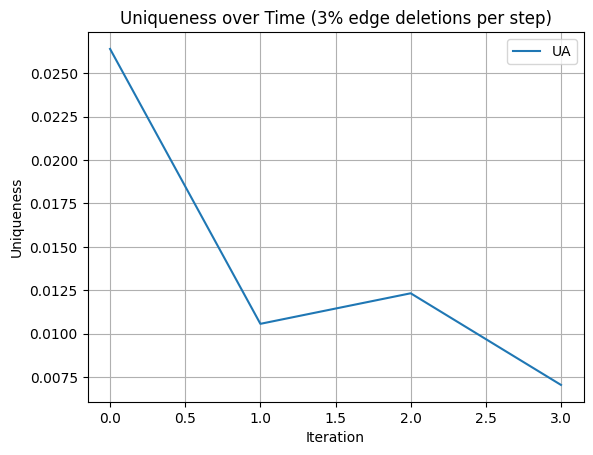

In [28]:
CALCULATE_TIME=G_origin.ecount() // 100*budgetDelete // STEP
G_ua= G_origin.copy()
edge_vec = edgeUA(G_origin, unodes_origin)
u_ua, t_ua, G_ua = UA1Round(G_ua, U, edge_vec, STEP, CALCULATE_TIME, criteria)
print("Results of UA with budget:".format(budgetDelete))
print("Final Uniqueness UA:", u_ua[-1])
print("Execution Time:", t_ua)
print("Final ACC:", G_ua.transitivity_avglocal_undirected(mode="zero"))
print("Final Transitivity:", G_ua.transitivity_undirected())
print("Final Number of Edges:", G_ua.ecount())

plt.figure()
plt.plot(u_ua, label='UA')
plt.xlabel('Iteration')
plt.ylabel('Uniqueness')
plt.title('Uniqueness over Time (3% edge deletions per step)')
plt.legend()
plt.grid(True)
plt.show()


## Greedy

Results of logistic regression with budget:
Final Uniqueness LR: 0.0
Execution Time: 0.4739856719970703
Final ACC: 0.12807260228034875
Final Transitivity: 0.14652014652014653
Final Number of Edges: 667


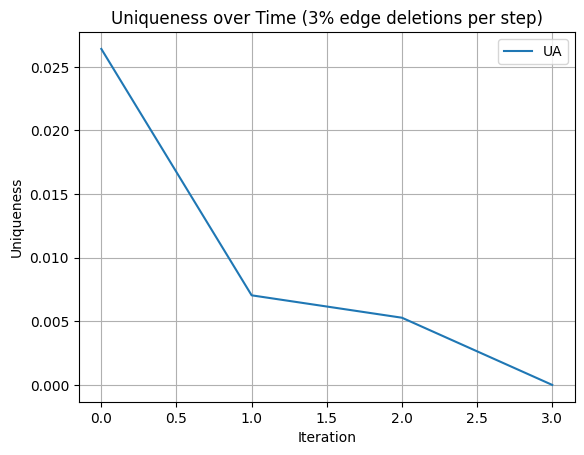

In [29]:
G_gnm= G_origin.copy()
edge_list = getEdgeListUnique(G_origin, unodes_origin)
edge_vec = edgeUA(G_origin, unodes_origin)
u_gnm, t_gnm = greedy1Round(G_gnm, U, STEP, CALCULATE_TIME, criteria)
print("Results of logistic regression with budget:".format(budgetDelete))
print("Final Uniqueness LR:", u_gnm[-1])
print("Execution Time:", t_gnm)
print("Final ACC:", G_gnm.transitivity_avglocal_undirected(mode="zero"))
print("Final Transitivity:", G_gnm.transitivity_undirected())
print("Final Number of Edges:", G_gnm.ecount())

plt.figure()
plt.plot(u_gnm, label='UA')
plt.xlabel('Iteration')
plt.ylabel('Uniqueness')
plt.title('Uniqueness over Time (3% edge deletions per step)')
plt.legend()
plt.grid(True)
plt.show()

## Logistic Regression

Results of logistic regression with budget:
Final Uniqueness LR: 0.00528169014084507
Execution Time: 1.0815811157226562
Final ACC: 0.12997987927565396
Final Transitivity: 0.13753056234718827
Final Number of Edges: 667


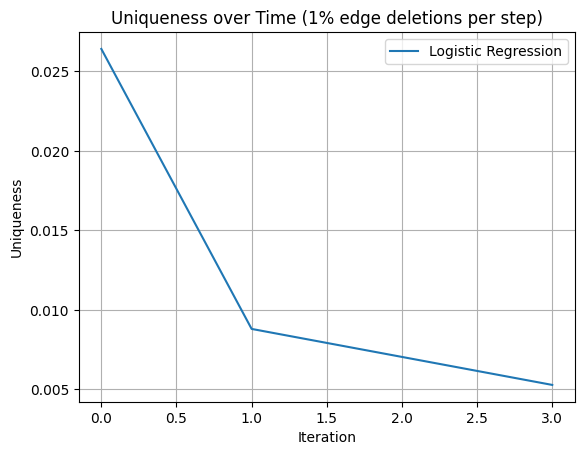

In [30]:
CALCULATE_TIME=G_origin.ecount() // 100*budgetDelete // STEP
G_lr = G_origin.copy()
u_lr, t_lr, G_lr = LR1Round(G_lr, U, unodes_origin, STEP, CALCULATE_TIME, criteria)
print("Results of logistic regression with budget:".format(budgetDelete))
print("Final Uniqueness LR:", u_lr[-1])
print("Execution Time:", t_lr)
print("Final ACC:", G_lr.transitivity_avglocal_undirected(mode="zero"))
print("Final Transitivity:", G_lr.transitivity_undirected())
print("Final Number of Edges:", G_lr.ecount())

plt.figure()
plt.plot(u_lr, label='Logistic Regression')
plt.xlabel('Iteration')
plt.ylabel('Uniqueness')
plt.title('Uniqueness over Time (1% edge deletions per step)')
plt.legend()
plt.grid(True)
plt.show()


## Simulated Annealing

Results of simulated annealing
Budget for edge deletions: 1
Number of iterations: 100
Final Uniqueness: 0.02640845070422535
Execution Time: 0.15314102172851562
Final ACC: 0.13905554539357357
Final Transitivity: 0.15388683236382866
Final Number of Edges: 697
number of removed edges: 0
Best uniqueness: 0.02640845070422535


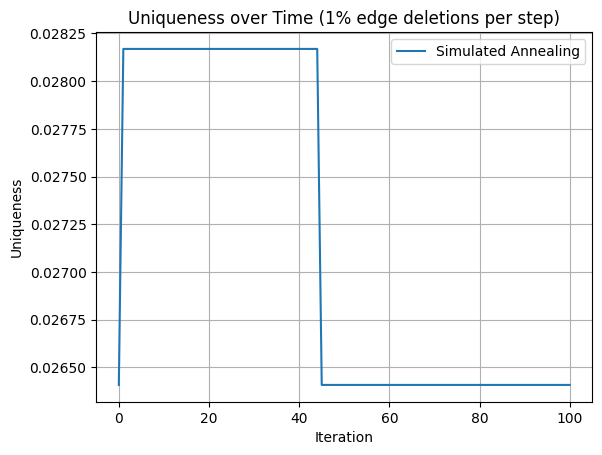

In [80]:
iterations=  100
G_final, u_SA, duration, best_u, best_edges = simulatedAnnealing_flipping(
    G_origin.copy(),                # Original graph
    E0,                             # Original edges
    U_origin=U,                     # Initial uniqueness score
    step=STEP,
    time_budget=  iterations,          # Number of iterations
    criteria=criteria,
    T0=10.0,                         # Initial temperature    
    alpha=0.9,                     # Cooling rate
    budget=budgetDelete,                # Budget for edge deletions
    noise_std=0.0                 # Noise standard deviation``
)
print("Results of simulated annealing")
print("Budget for edge deletions:", budgetDelete)
print("Number of iterations:", iterations)
print("Final Uniqueness:", u_SA[-1])    
print("Execution Time:", duration)
print("Final ACC:", G_final.transitivity_avglocal_undirected(mode="zero"))
print("Final Transitivity:", G_final.transitivity_undirected())
print("Final Number of Edges:", G_final.ecount())
print("number of removed edges:", len(E0)-len(best_edges))
# print("Best edges:", best_edges)
print("Best uniqueness:", best_u)
plt.figure()
plt.plot(u_SA, label='Simulated Annealing') 
plt.xlabel('Iteration')
plt.ylabel('Uniqueness')
plt.title('Uniqueness over Time (1% edge deletions per step)')
plt.legend()
plt.grid(True)
plt.show()
# Save results  





Converged: T₀ = 0.01178 (after 2 iterations)
Stopping early at iteration 21714 due to no improvement for 4000 steps.
Results of simulated annealing
Budget for edge deletions: 1
Number of iterations: 4000
Final Uniqueness: 0.34625
Execution Time: 5.847174406051636
Final ACC: 0.3134350394505048
Final Transitivity: 0.24321035488987638
Final Number of Edges: 6366
number of removed edges: 63
max number of anonymized nodes in one edge deletion: 5
Best uniqueness: 0.34625


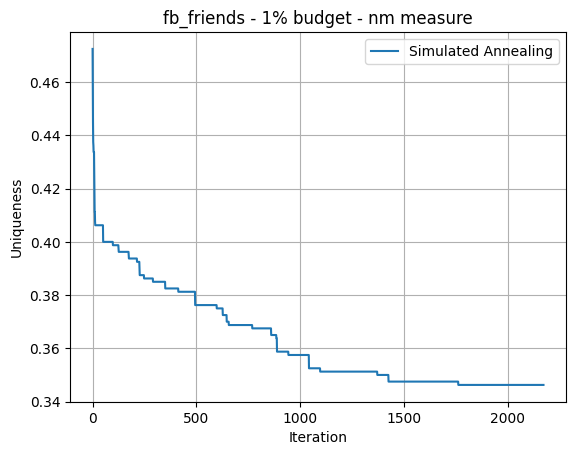

In [121]:
iterations=  50 * G_origin.vcount() // STEP
T0 = estimate_T0_walid(G_origin.copy(), E0, sample_size=100, chi0=0.8)
patience_ratio = 1
patience = int(patience_ratio * iterations)
# TITI
G_final_opt, u_SA_opt, duration_opt, best_u_opt, best_edges_opt, maxAnonNodes = simulatedAnnealing_flipping_sus(
    G_origin.copy(),                # Original graph
    E0,                             # Original edges
    U_origin=U,                     # Initial uniqueness score
    step=STEP,
    time_budget=  iterations,          # Number of iterations
    criteria=criteria,
    T0= T0 ,                   # Initial temperature    
    alpha=0.85,                     # Cooling rate
    budget=budgetDelete,                # Budget for edge deletions
    patience=patience,                # Patience for early stopping
    noise_std=0.0               # Noise standard deviation``
)
print("Results of simulated annealing")
print("Budget for edge deletions:", budgetDelete)
print("Number of iterations:", iterations)
print("Final Uniqueness:", u_SA_opt[-1])    
print("Execution Time:", duration_opt)
print("Final ACC:", G_final_opt.transitivity_avglocal_undirected(mode="zero"))
print("Final Transitivity:", G_final_opt.transitivity_undirected())
print("Final Number of Edges:", G_final_opt.ecount())
print("number of removed edges:", len(E0)-len(best_edges_opt))
print("max number of anonymized nodes in one edge deletion: {}".format(maxAnonNodes))
# print("Best edges:", best_edges)
print("Best uniqueness:", best_u_opt)
plt.figure()
plt.plot(u_SA_opt, label='Simulated Annealing'.format(document, budgetDelete))
plt.xlabel('Iteration')
plt.ylabel('Uniqueness')
plt.title('{} - {}% budget - {} measure'.format(document, budgetDelete, criteria))
plt.legend()
plt.grid(True)




In [40]:
print("Final graph uniqueness not optimized SA(nm):")
print(uniqueness(build_graph_from_edges(G_origin.copy(), best_edges), 'nm'))
print("Final graph uniqueness optimized SA(nm):")
print(uniqueness(build_graph_from_edges(G_origin.copy(), best_edges_opt), 'nm'))


Final graph uniqueness not optimized SA(nm):
(0.007042253521126761, {216, 333, 53, 255})
Final graph uniqueness optimized SA(nm):
(0.00528169014084507, {216, 101, 165})


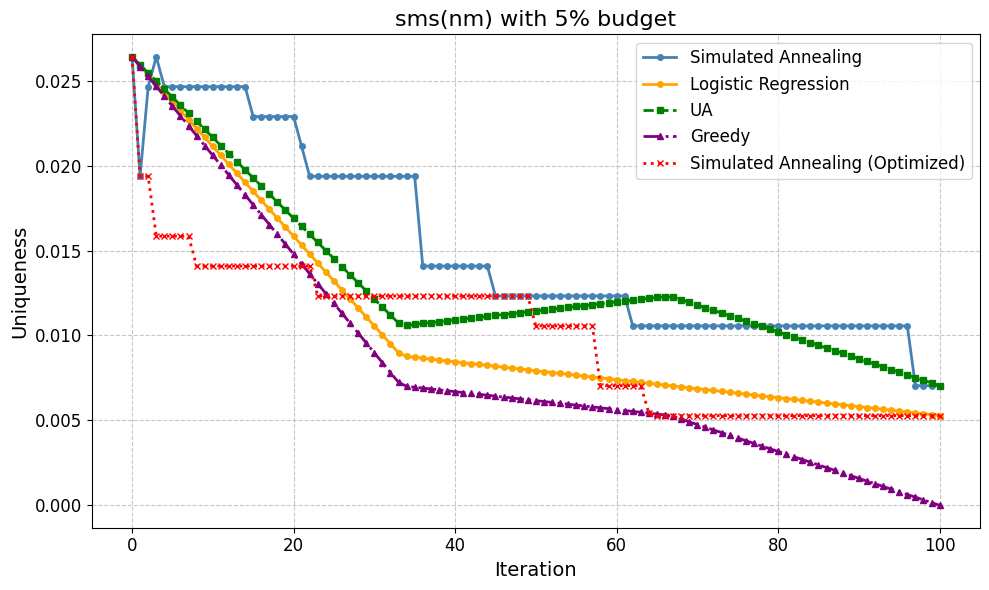

In [41]:
# Interpolate u_ua and u_gnm to match the number of points in u_SA
x_ua = np.linspace(0, len(u_SA)-1, len(u_ua))
x_gnm = np.linspace(0, len(u_SA)-1, len(u_gnm))
x_lr = np.linspace(0, len(u_SA)-1, len(u_lr))
x_SAOpt= np.linspace(0, len(u_SA)-1, len(u_SA_opt))
x_interp = np.arange(len(u_SA))  # match x-axis of u_SA
u_ua_interp = np.interp(x_interp, x_ua, u_ua)
u_gnm_interp = np.interp(x_interp, x_gnm, u_gnm)
u_lr_interp = np.interp(x_interp, x_lr, u_lr)
u_SA_opt_interp = np.interp(x_interp, x_SAOpt, u_SA_opt)
plt.figure(figsize=(10, 6))
plt.plot(u_SA, marker='o', linestyle='-', color='steelblue', linewidth=2, markersize=4, label='Simulated Annealing')
plt.plot(u_lr_interp, marker='o', linestyle='-', color='orange', linewidth=2, markersize=4, label='Logistic Regression')
plt.plot(u_ua_interp, marker='s', linestyle='--', color='green', linewidth=2, markersize=4, label='UA')
plt.plot(u_gnm_interp, marker='^', linestyle='-.', color='purple', linewidth=2, markersize=4, label='Greedy')
plt.plot(u_SA_opt_interp, marker='x', linestyle=':', color='red', linewidth=2, markersize=4, label='Simulated Annealing (Optimized)')
plt.title("{}({}) with {}% budget".format(document, criteria, budgetDelete), fontsize=16)
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Uniqueness", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [35]:
if mode == "SA":
    # run U/A method
    iterations=  100
    G_final, u_progress, duration, best_u, best_edges = simulatedAnnealing_flipping(
        G_origin.copy(),                # Original graph
        E0,                             # Original edges
        U_origin=U,                     # Initial uniqueness score
        step=STEP,
        time_budget=  iterations,          # Number of iterations
        criteria=criteria,
        T0=0.1,                         # Initial temperature    
        alpha=0.75,                     # Cooling rate
        budget=budgetDelete,                # Budget for edge deletions
        noise_std=0.0001                  # Noise standard deviation``
    )
    print("Results of simulated annealing")
    print("Budget for edge deletions:", budgetDelete)
    print("Number of iterations:", iterations)
    print("Final Uniqueness:", u_progress[-1])    
    print("Execution Time:", duration)
    print("Final ACC:", G_final.transitivity_avglocal_undirected(mode="zero"))
    print("Final Transitivity:", G_final.transitivity_undirected())
    print("Final Number of Edges:", G_final.ecount())
    print("number of removed edges:", len(E0)-len(best_edges))
    # print("Best edges:", best_edges)
    print("Best uniqueness:", best_u)
    with open('./intermediate results/UA-CopenFB-10-NM-10STEP.txt', 'wb') as f:
        pickle.dump(u_progress, f)
    print('Finished SA')

elif mode == "lr":
    # run LR method
    CALCULATE_TIME=G_origin.ecount() // 100*budgetDelete // STEP
    G_lr = G_origin.copy()
    u_lr, t_lr, G_lr = LR1Round(G_lr, U, unodes_origin, STEP, CALCULATE_TIME, 'nm')
    print("Results of logistic regression with budget:".format(budgetDelete))
    print("Final Uniqueness LR:", u_lr[-1])
    print("Execution Time:", t_lr)
    print("Final ACC:", G_lr.transitivity_avglocal_undirected(mode="zero"))
    print("Final Transitivity:", G_lr.transitivity_undirected())
    print("Final Number of Edges:", G_lr.ecount())
    with open('./intermediate results/LR-CopenFB-10-NM-10STEP.txt', 'wb') as f:
        pickle.dump(u_lr, f)
    print('Finished LR')


In [43]:
import sys
print(sys.version)

3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]
